#  Unit 2.4a Using Programs with Data, SQLAlchemy
> Using Programs with Data is focused on SQL and database actions.  Part A focuses on SQLAlchemy and an OOP programming style,
- toc: true
- image: /images/python.png
- categories: []
- type: ap
- week: 26

# Database and SQLAlchemy
> In this blog we will explore using programs with data, focused on Databases.  We will use SQLite Database to learn more about using Programs with Data.  ***Use Debugging through these examples to examine Objects created in Code***.

- College Board talks about ideas like 
    - Program Usage. "iterative and interactive way when processing information"
    - Managing Data.  "classifying data are part of the process in using programs", "data files in a Table"
    - Insight "insight and knowledge can be obtained from ...  digitally represented information"
    - Filter systems. 'tools for finding information and recognizing patterns"
    - Application. "the preserve has two databases", "an employee wants to count the number of book"

- PBL, Databases, Iterative/OOP
    - Iterative. Refers to a sequence of instructions or code being repeated until a specific end result is achieved
    - OOP. A computer programming model that organizes software design around data, or objects, rather than functions and logic
    - SQL. Structured Query Language, abbreviated as SQL, is a language used in programming, managing, and structuring data 


## Imports and Flask Objects
> Defines and key object creations

- Comment on where you have observed these working?  Provide a defintion of purpose.
    1. Flask app object

    An object used for configuring a SQL database, used to create one last trimester
    
    2. SQLAlchemy db object
    
    An object Used as a database


In [2]:
"""
These imports define the key objects
"""

from flask import Flask
from flask_sqlalchemy import SQLAlchemy

"""
These object and definitions are used throughout the Jupyter Notebook.
"""

# Setup of key Flask object (app)
app = Flask(__name__)
# Setup SQLAlchemy object and properties for the database (db)
database = 'sqlite:///sqlite.db'  # path and filename of database
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
app.config['SQLALCHEMY_DATABASE_URI'] = database
app.config['SECRET_KEY'] = 'SECRET_KEY'
db = SQLAlchemy()


# This belongs in place where it runs once per project
db.init_app(app)


## Model Definition
> Define columns, initialization, and CRUD methods for users table in sqlite.db

- Comment on these items in the class, purpose and defintion.
    - class User

    A class that contains all the nessesary method to modify an entry in the database 
    
    - db.Model inheritance
    
    used to make sure the new User object xan work with the database
    
    - _init_ method
    
    initialized values in the database
    
    - ```@property```, ```@<column>.setter```
    
    Marking which functions is used for the CRUD methods
    
    - create, read, update, delete methods
    
    Methods to manipulate entries in the database

In [3]:
""" database dependencies to support sqlite examples """
import datetime
from datetime import datetime
import json

from sqlalchemy.exc import IntegrityError
from werkzeug.security import generate_password_hash, check_password_hash


''' Tutorial: https://www.sqlalchemy.org/library.html#tutorials, try to get into a Python shell and follow along '''

# Define the User class to manage actions in the 'users' table
# -- Object Relational Mapping (ORM) is the key concept of SQLAlchemy
# -- a.) db.Model is like an inner layer of the onion in ORM
# -- b.) User represents data we want to store, something that is built on db.Model
# -- c.) SQLAlchemy ORM is layer on top of SQLAlchemy Core, then SQLAlchemy engine, SQL
class User(db.Model):
    __tablename__ = 'users'  # table name is plural, class name is singular

    # Define the User schema with "vars" from object
    id = db.Column(db.Integer, primary_key=True)
    _name = db.Column(db.String(255), unique=False, nullable=False)
    _uid = db.Column(db.String(255), unique=True, nullable=False)
    _password = db.Column(db.String(255), unique=False, nullable=False)
    _dob = db.Column(db.Date)

    # constructor of a User object, initializes the instance variables within object (self)
    def __init__(self, name, uid, password="123qwerty", dob=datetime.today()):
        self._name = name    # variables with self prefix become part of the object, 
        self._uid = uid
        self.set_password(password)
        if isinstance(dob, str):  # not a date type     
            dob = date=datetime.today()
        self._dob = dob

    # a name getter method, extracts name from object
    @property
    def name(self):
        return self._name
    
    # a setter function, allows name to be updated after initial object creation
    @name.setter
    def name(self, name):
        self._name = name
    
    # a getter method, extracts uid from object
    @property
    def uid(self):
        return self._uid
    
    # a setter function, allows uid to be updated after initial object creation
    @uid.setter
    def uid(self, uid):
        self._uid = uid
        
    # check if uid parameter matches user id in object, return boolean
    def is_uid(self, uid):
        return self._uid == uid
    
    @property
    def password(self):
        return self._password[0:10] + "..." # because of security only show 1st characters

    # update password, this is conventional method used for setter
    def set_password(self, password):
        """Create a hashed password."""
        self._password = generate_password_hash(password, method='sha256')

    # check password parameter against stored/encrypted password
    def is_password(self, password):
        """Check against hashed password."""
        result = check_password_hash(self._password, password)
        return result
    
    # dob property is returned as string, a string represents date outside object
    @property
    def dob(self):
        dob_string = self._dob.strftime('%m-%d-%Y')
        return dob_string
    
    # dob setter, verifies date type before it is set or default to today
    @dob.setter
    def dob(self, dob):
        if isinstance(dob, str):  # not a date type     
            dob = date=datetime.today()
        self._dob = dob
    
    # age is calculated field, age is returned according to date of birth
    @property
    def age(self):
        today = datetime.today()
        return today.year - self._dob.year - ((today.month, today.day) < (self._dob.month, self._dob.day))
    
    # output content using str(object) is in human readable form
    # output content using json dumps, this is ready for API response
    def __str__(self):
        return json.dumps(self.read())

    # CRUD create/add a new record to the table
    # returns self or None on error
    def create(self):
        try:
            # creates a person object from User(db.Model) class, passes initializers
            db.session.add(self)  # add prepares to persist person object to Users table
            db.session.commit()  # SqlAlchemy "unit of work pattern" requires a manual commit
            return self
        except IntegrityError:
            db.session.remove()
            return None

    # CRUD read converts self to dictionary
    # returns dictionary
    def read(self):
        return {
            "id": self.id,
            "name": self.name,
            "uid": self.uid,
            "dob": self.dob,
            "age": self.age,
        }

    # CRUD update: updates user name, password, phone
    # returns self
    def update(self, name="", uid="", password=""):
        """only updates values with length"""
        if len(name) > 0:
            self.name = name
        if len(uid) > 0:
            self.uid = uid
        if len(password) > 0:
            self.set_password(password)
        db.session.add(self) # performs update when id exists
        db.session.commit()
        return self

    # CRUD delete: remove self
    # None
    def delete(self):
        db.session.delete(self)
        db.session.commit()
        return None
    

## Initial Data
> Uses SQLALchemy db.create_all() to initialize rows into sqlite.db

- Comment on how these work?
    1. Create All Tables from db Object
    
    using db to create the database and all its columns
    
    2. User Object Constructors
    
    Creating the individual objects
    
    3. Try / Except
    
    To prevent errors in adding the entries. 


In [4]:
"""Database Creation and Testing """


# Builds working data for testing
def initUsers():
    with app.app_context():
        """Create database and tables"""
        db.create_all()
        """Tester data for table"""
        u1 = User(name='Thomas Edison', uid='toby', password='123toby', dob=datetime(1847, 2, 11))
        u2 = User(name='Nikola Tesla', uid='niko', password='123niko')
        u3 = User(name='Alexander Graham Bell', uid='lex', password='123lex')
        u4 = User(name='Eli Whitney', uid='whit', password='123whit')
        u5 = User(name='Indiana Jones', uid='indi', dob=datetime(1920, 10, 21))
        u6 = User(name='Marion Ravenwood', uid='raven', dob=datetime(1921, 10, 21))


        users = [u1, u2, u3, u4, u5, u6]

        """Builds sample user/note(s) data"""
        for user in users:
            try:
                '''add user to table'''
                object = user.create()
                print(f"Created new uid {object.uid}")
            except:  # error raised if object nit created
                '''fails with bad or duplicate data'''
                print(f"Records exist uid {user.uid}, or error.")
                
initUsers()

Created new uid toby
Created new uid niko
Created new uid lex
Created new uid whit
Created new uid indi
Created new uid raven


## Check for given Credentials in users table in sqlite.db
> Use of ORM Query object and custom methods to identify user to credentials uid and password

- Comment on purpose of following
    
    1. User.query.filter_by
    
    Look for the exact query
    
    2. user.password
    
    check if the password parameter is the same as the object's password

In [5]:
# SQLAlchemy extracts single user from database matching User ID
def find_by_uid(uid):
    with app.app_context():
        user = User.query.filter_by(_uid=uid).first()
    return user # returns user object

# Check credentials by finding user and verify password
def check_credentials(uid, password):
    # query email and return user record
    user = find_by_uid(uid)
    if user == None:
        return False
    if (user.is_password(password)):
        return True
    return False
        
#check_credentials("indi", "123qwerty")

## Create a new User in table in Sqlite.db
> Uses SQLALchemy and custom user.create() method to add row.

- Comment on purpose of following
    1. user.find_by_uid() and try/except
    
    Look for a user by uid and if there is already one, return the read variables, otherwise, add the variables
    
    2. user = User(...)
    
    Creating a User object for this create function
    
    3. user.dob and try/except
    
    Asking the user to create the date of birth, if it's not a data of birth, default it to today's date
    
    4. user.create() and try/except
    
    Create the User object as an entry in the database, if fails, returns an error message and the uid

In [6]:
# Inputs, Try/Except, and SQLAlchemy work together to build a valid database object
def create():
    # optimize user time to see if uid exists
    uid = input("Enter your user id:")
    user = find_by_uid(uid)
    try:
        print("Found\n", user.read())
        return
    except:
        pass # keep going
    
    # request value that ensure creating valid object
    name = input("Enter your name:")
    password = input("Enter your password")
    
    # Initialize User object before date
    user = User(name=name, 
                uid=uid, 
                password=password
                )
    
    # create user.dob, fail with today as dob
    dob = input("Enter your date of birth 'YYYY-MM-DD'")
    try:
        user.dob = datetime.strptime(dob, '%Y-%m-%d').date()
    except ValueError:
        user.dob = datetime.today()
        print(f"Invalid date {dob} require YYYY-mm-dd, date defaulted to {user.dob}")
           
    # write object to database
    with app.app_context():
        try:
            object = user.create()
            print("Created\n", object.read())
        except:  # error raised if object not created
            print("Unknown error uid {uid}")
        
create()

Invalid date  require YYYY-mm-dd, date defaulted to 03-20-2023
Created
 {'id': 7, 'name': '', 'uid': '', 'dob': '03-20-2023', 'age': 0}


## Reading users table in sqlite.db
> Uses SQLALchemy query.all method to read data

- Comment on purpose of following
    1. User.query.all
    
    Get all of the User entries
    
    2. json_ready assignment, google List Comprehension
    
    creating a list of dictionaries that can be converted to json and transported.

In [9]:

# SQLAlchemy extracts all users from database, turns each user into JSON
def read():
    with app.app_context():
        table = User.query.all()
    json_ready = [user.read() for user in table] # "List Comprehensions", for each user add user.read() to list
    return json_ready

read()

[{'id': 1,
  'name': 'Thomas Edison',
  'uid': 'toby',
  'dob': '02-11-1847',
  'age': 176},
 {'id': 2,
  'name': 'Nikola Tesla',
  'uid': 'niko',
  'dob': '03-20-2023',
  'age': 0},
 {'id': 3,
  'name': 'Alexander Graham Bell',
  'uid': 'lex',
  'dob': '03-20-2023',
  'age': 0},
 {'id': 4,
  'name': 'Eli Whitney',
  'uid': 'whit',
  'dob': '03-20-2023',
  'age': 0},
 {'id': 5,
  'name': 'Indiana Jones',
  'uid': 'indi',
  'dob': '10-21-1920',
  'age': 102},
 {'id': 6,
  'name': 'Marion Ravenwood',
  'uid': 'raven',
  'dob': '10-21-1921',
  'age': 101},
 {'id': 7, 'name': '', 'uid': '', 'dob': '03-20-2023', 'age': 0}]

# Hacks
- Add this Blog to you own Blogging site.  In the Blog add notes and observations on each code cell.
- Change blog to your own database.
- Add additional CRUD
    - Add Update functionality to this blog.
    - Add Delete functionality to this blog.

In [8]:
def update():
    # get the information for the user to be updated
    uid = input("Enter uid of user to be updated")
    user = find_by_uid(uid)
    name = input("Enter new name (leave blank if no need to update):")
    password = input("Enter new password (leave blank if no need to update):")
    with app.app_context():
        try:
            object = user.update(name=name,uid=uid, password=password) 
            print(f"User with uid --{uid}-- has been updated: {object} ")
        except:  # error raised if object not found
           (f"No user with uid {uid} was found.")

def delete():
    # get the 
    uid = input("Enter uid of user to be deleted.")
    user = find_by_uid(uid)  # using previous function to locate user by inputted id
    with app.app_context():
        try:
            object = user.delete() 
            print(f"User with uid --{uid}-- has been deleted. ")
            db = read()
            print(db)
        except:  # error raised if object not found
           (f"No user with uid {uid} was found.")


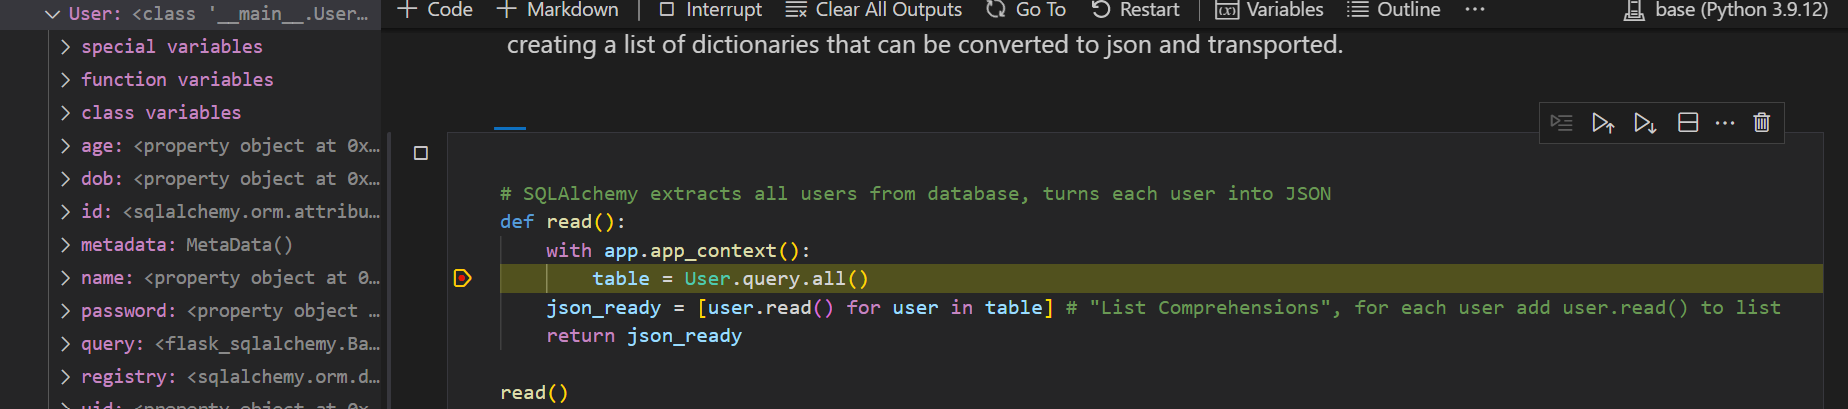